In [1]:
import os
from os.path import join
# Set working directory
os.chdir('/home/pedro/git2/gitflow/air_pollution_forecast')

import sys
sys.path.append('./eoas_pyutils')
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
import matplotlib.pyplot as plt
from torchsummary import summary
from conf.localConstants import constants
from proj_io.inout import (
    create_folder, add_previous_hours, get_column_names,
    read_merged_files, save_columns
)
# add_forecasted_hours,
from proj_preproc.preproc import loadScaler
from proj_prediction.prediction import  analyze_column
from pytorch_proj import (
    normalizeData, split_train_validation_and_test, apply_bootstrap, plot_forecast_hours
)

In [2]:
def filter_data(df, filter_type='none', filtered_pollutant='', filtered_station=''):
    """
    Filtra el DataFrame según el tipo de filtro especificado.
    Los posibles valores de filter_type son: 'none', 'single_pollutant', 'single_pollutant_and_station'
    """
    all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(df)
    
    if filter_type == 'single_pollutant':
        filtered_pollutants = filtered_pollutant if isinstance(filtered_pollutant, list) else [filtered_pollutant]
        keep_cols = [x for x in df.columns if any(pollutant in x for pollutant in filtered_pollutants)]
        keep_cols += all_time_colums.tolist() + all_meteo_columns.tolist()
        
    elif filter_type == 'single_pollutant_and_station':
        keep_cols = [f'cont_{filtered_pollutant}_{filtered_station}'] + all_time_colums.tolist() + all_meteo_columns
    
    elif filter_type == 'none':
        return df.copy()

    print(f"Keeping columns: {len(keep_cols)} original columns: {len(df.columns)}")
    return df[keep_cols].copy()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hours_before = 0 #24
replace_nan_value = 0
data_folder = '/ZION/AirPollutionData/Data/'
grid_size = 4
merged_specific_folder = f'{grid_size*grid_size}'
input_folder = join(data_folder, 'MergedDataCSV/16/BK2/')
output_folder = join(data_folder, 'TrainingTestsPS2024')
norm_folder = join(output_folder, 'norm')
split_info_folder = join(output_folder, 'Splits')

val_perc = 0.1
test_perc = 0
epochs = 5000
batch_size = 5000
bootstrap = True
boostrap_factor = 15
boostrap_threshold = 2.9
model_name_user = 'TestPSpyt'
start_year = 2010
end_year = 2018
test_year = 2013
cur_pollutant = 'otres'
cur_station = 'MER'
forecasted_hours = 1
norm_type = 'meanzero var 1'
stations_2020 = [
    "UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM", 
    "IZT", "CCA", "HGM", "LPR", "MGH", "CAM", "FAC", "TLA", "MER", "XAL", 
    "LLA", "TLI", "UAX", "BJU", "MPA", "MON", "NEZ", "INN", "AJM", "VIF"
]
stations = stations_2020
pollutants = "cont_otres"

In [4]:
folders = ['Splits', 'Parameters', 'models', 'logs', 'imgs', 'norm']
for folder in folders:
    create_folder(join(output_folder, folder))

In [5]:
now = datetime.utcnow().strftime("%Y_%m_%d_%H_%M")
model_name = f'{model_name_user}_{cur_pollutant}_{now}'

In [6]:


imputed_files_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1'

# Function to load imputed data for all years and recreate the DataFrame
def load_imputed_data(start_year, end_year, folder_path):
    all_data = []
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(folder_path, f'data_imputed_{year}.csv')
        print(f"Loading data from {file_path}")
        yearly_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        all_data.append(yearly_data)
    data_imputed_df = pd.concat(all_data)
    data_imputed_df.index = pd.to_datetime(data_imputed_df.index)
    return data_imputed_df

# Load the imputed data

data_imputed_df = load_imputed_data(start_year,end_year, imputed_files_folder)
print(data_imputed_df)

Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2010.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2011.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2012.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2013.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2014.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2015.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2016.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2017.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2018.csv


                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2010-01-01 00:00:00             2.0        4.777778        4.777778   
2010-01-01 01:00:00             2.0        5.000000        5.000000   
2010-01-01 02:00:00             2.0        9.444444        9.444444   
2010-01-01 03:00:00            18.0       18.222222       18.222222   
2010-01-01 04:00:00            20.0       20.444444       20.444444   
...                             ...             ...             ...   
2018-12-31 19:00:00            19.0       40.000000       32.000000   
2018-12-31 20:00:00            19.0       18.000000       10.000000   
2018-12-31 21:00:00             9.0        6.000000        4.000000   
2018-12-31 22:00:00            13.0        6.000000       11.000000   
2018-12-31 23:00:00             4.0        4.000000        8.000000   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2010-01-01 00:00:00        4.777778        4.777778            12.0   
2010-

In [7]:
print(data_imputed_df.tail())

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2018-12-31 19:00:00            19.0            40.0            32.0   
2018-12-31 20:00:00            19.0            18.0            10.0   
2018-12-31 21:00:00             9.0             6.0             4.0   
2018-12-31 22:00:00            13.0             6.0            11.0   
2018-12-31 23:00:00             4.0             4.0             8.0   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2018-12-31 19:00:00            25.0            34.0            17.0   
2018-12-31 20:00:00            15.0            11.0             6.0   
2018-12-31 21:00:00             5.0             9.0             5.0   
2018-12-31 22:00:00             3.0             4.0             0.0   
2018-12-31 23:00:00             6.0            13.0             0.0   

                     cont_otres_CUT  cont_otres_PED  cont_otres_TAH  \
2018-12-31 19:00:00            31.0            49.0            16.0   
2018

In [8]:
data_imputed  = data_imputed_df

In [9]:
# Filtrar las columnas imputadas y sus flags solo para los grupos específicos
selected_prefixes = ['cont_otres_', 'cont_pmdiez_', 'cont_pmdoscinco_', 'cont_nodos_', 'cont_co_', 'i_']
additional_columns = [
    'half_sin_day', 'half_cos_day', 'half_sin_week', 'half_cos_week', 
    'half_sin_year', 'half_cos_year', 'sin_day', 'cos_day', 
    'sin_week', 'cos_week', 'sin_year', 'cos_year'
]
imputed_columns_filtered = [col for col in data_imputed.columns 
                            if any(col.startswith(prefix) for prefix in selected_prefixes) and 
                            (col in data_imputed.columns or col.endswith('_i'))] + additional_columns

# Crear el subset con las columnas seleccionadas
data_imputed_subset = data_imputed[imputed_columns_filtered].copy()

# Reordenar las columnas: primero las columnas seleccionadas, luego additional_columns, y finalmente las que empiezan con "i_"
ordered_columns = [col for col in imputed_columns_filtered if not col.startswith('i_') and col not in additional_columns] + additional_columns + [col for col in imputed_columns_filtered if col.startswith('i_')]
data_imputed_subset = data_imputed_subset[ordered_columns]

# Mostrar información del subset
print("Subset de datos con columnas imputadas y sus flags:")
print(data_imputed_subset.info())
print(data_imputed_subset.head())

Subset de datos con columnas imputadas y sus flags:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78888 entries, 2010-01-01 00:00:00 to 2018-12-31 23:00:00
Columns: 280 entries, cont_otres_UIZ to i_cont_co_VIF
dtypes: float64(146), object(134)
memory usage: 169.1+ MB
None
                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2010-01-01 00:00:00             2.0        4.777778        4.777778   
2010-01-01 01:00:00             2.0        5.000000        5.000000   
2010-01-01 02:00:00             2.0        9.444444        9.444444   
2010-01-01 03:00:00            18.0       18.222222       18.222222   
2010-01-01 04:00:00            20.0       20.444444       20.444444   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2010-01-01 00:00:00        4.777778        4.777778            12.0   
2010-01-01 01:00:00        5.000000        5.000000             6.0   
2010-01-01 02:00:00        9.444444        9.444444            18.0   
2010-01-0

In [10]:
for each in data_imputed_subset.columns:
    print(each)

cont_otres_UIZ
cont_otres_AJU
cont_otres_ATI
cont_otres_CUA
cont_otres_SFE
cont_otres_SAG
cont_otres_CUT
cont_otres_PED
cont_otres_TAH
cont_otres_GAM
cont_otres_IZT
cont_otres_CCA
cont_otres_HGM
cont_otres_LPR
cont_otres_MGH
cont_otres_CAM
cont_otres_FAC
cont_otres_TLA
cont_otres_MER
cont_otres_XAL
cont_otres_LLA
cont_otres_TLI
cont_otres_UAX
cont_otres_BJU
cont_otres_MPA
cont_otres_MON
cont_otres_NEZ
cont_otres_INN
cont_otres_AJM
cont_otres_VIF
cont_pmdoscinco_UIZ
cont_pmdoscinco_AJU
cont_pmdoscinco_SFE
cont_pmdoscinco_SAG
cont_pmdoscinco_PED
cont_pmdoscinco_GAM
cont_pmdoscinco_CCA
cont_pmdoscinco_HGM
cont_pmdoscinco_MGH
cont_pmdoscinco_CAM
cont_pmdoscinco_TLA
cont_pmdoscinco_MER
cont_pmdoscinco_XAL
cont_pmdoscinco_UAX
cont_pmdoscinco_BJU
cont_pmdoscinco_MPA
cont_pmdoscinco_MON
cont_pmdoscinco_NEZ
cont_pmdoscinco_INN
cont_pmdoscinco_AJM
cont_co_UIZ
cont_co_ATI
cont_co_CUA
cont_co_SFE
cont_co_SAG
cont_co_CUT
cont_co_PED
cont_co_TAH
cont_co_IZT
cont_co_CCA
cont_co_HGM
cont_co_LPR
cont_c

In [11]:
# Convertir valores 'none' en flags a 1, los valores 'row_avg' a 2, 'last_day_same_hour' a 3
for col in data_imputed_subset.columns:
    if col.startswith('i_'):
        data_imputed_subset[col] = data_imputed_subset[col].replace({
            'none': 1,
            'row_avg': 2,
            'last_day_same_hour': 3
        })

In [12]:
print(data_imputed_subset.head())

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2010-01-01 00:00:00             2.0        4.777778        4.777778   
2010-01-01 01:00:00             2.0        5.000000        5.000000   
2010-01-01 02:00:00             2.0        9.444444        9.444444   
2010-01-01 03:00:00            18.0       18.222222       18.222222   
2010-01-01 04:00:00            20.0       20.444444       20.444444   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2010-01-01 00:00:00        4.777778        4.777778            12.0   
2010-01-01 01:00:00        5.000000        5.000000             6.0   
2010-01-01 02:00:00        9.444444        9.444444            18.0   
2010-01-01 03:00:00       18.222222       18.222222            16.0   
2010-01-01 04:00:00       20.444444       20.444444            17.0   

                     cont_otres_CUT  cont_otres_PED  cont_otres_TAH  \
2010-01-01 00:00:00        4.777778             5.0             8.0   
2010

In [13]:
def preprocessing_data_step0(data, gen_col_csv=True, file_name_norm=None):
    """ Preprocessing data """
    if file_name_norm:
        def normalizeDataWithLoadedScaler(data, file_name):
                """
                Normalize data using a pre-saved scaler object.

                :param data: DataFrame to be normalized
                :param file_name: Path to the scaler .pkl file
                :return: Normalized DataFrame
                """
                # Load the scaler object from the file
                with open(file_name, 'rb') as f:
                    scaler = pickle.load(f)
                
                # Transform the data using the loaded scaler
                data_norm_np = scaler.transform(data)
                data_norm_df = pd.DataFrame(data_norm_np, columns=data.columns, index=data.index)
                
                print(f'Scaler/normalizer object loaded from: {file_name}')
                print(f'Done! Current shape: {data_norm_df.shape}')
                return data_norm_df
        data_norm_df = normalizeDataWithLoadedScaler(data, file_name_norm)
    else:
        file_name_norm = join(norm_folder, f"{model_name}_scaler.pkl")  
        print("Normalizing data....")
        data_norm_df = normalizeData(data, "mean_zero", file_name_norm)

    # Here we remove all the data of other pollutants
    X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                       filtered_pollutant=['otres', 'pmdiez', 'pmdoscinco', 'nodos'])

    print(X_df.columns.values)
    print(f'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum() / 1024 ** 2:02f} MB')

    print("Building X...")
    X_df = add_previous_hours(X_df, hours_before=hours_before)

    def add_forecasted_hours(df, forecasted_hours=range(1, 25)):
        '''
        This function adds the forecasted hours of all columns in the dataframe
        forecasted_hours: Array with the hours to forecast
        '''
        new_Y_columns = {}

        # Loop to create the shifted columns
        for c_hour in forecasted_hours:
            for c_column in df.columns:
                new_column_name = f'plus_{c_hour:02d}_{c_column}'
                new_Y_columns[new_column_name] = df[c_column].shift(-c_hour)

        # Concatenate all new columns at once
        Y_df = pd.concat([pd.DataFrame(new_Y_columns)], axis=1)

        print(f"Shape of Y: {Y_df.shape}")
        print("Done!")
        return Y_df

    print("Building Y...:Adding the forecasted hours of the pollutant as the predicted column Y...")
    Y_df = add_forecasted_hours(X_df, range(1, forecasted_hours + 1))

    X_df = X_df.iloc[hours_before:, :]
    Y_df = Y_df.iloc[hours_before:, :]
    column_y_csv = join(output_folder, 'Y_columns.csv')
    column_x_csv = join(output_folder, 'X_columns.csv')
    if gen_col_csv:
        save_columns(Y_df, column_y_csv)
        save_columns(X_df, column_x_csv)

    print("Done!")

    print(f'Original {data_norm_df.shape}')
    print(f'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum() / 1024 ** 2:02f} MB')
    print(f'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum() / 1024 ** 2:02f} MB')

    return X_df, Y_df, column_x_csv, column_y_csv, file_name_norm

def preprocessing_data_step1(X_df, Y_df):
    """ Preprocessing data """
    print("Splitting training and validation data by year....")
    #splits_file = join(split_info_folder, f'splits_{model_name}.csv')
    splits_file = None
    # Here we remove the datetime indexes so we need to consider that 
    train_idxs, val_idxs, _ = split_train_validation_and_test(
        len(X_df), val_perc, test_perc, shuffle_ids=False, file_name=splits_file)
    
    #Y_df.reset_index(drop=True, inplace=True)

    X_df_train = X_df.iloc[train_idxs]
    Y_df_train = Y_df.iloc[train_idxs]

    X_df_val = X_df.iloc[val_idxs]
    Y_df_val = Y_df.iloc[val_idxs]

    print(f'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
    print(f'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
    print(f'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum() / 1024 ** 2:02f} MB')
    print(f'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum() / 1024 ** 2:02f} MB')

    print("Done!")

    if bootstrap:            
        # Bootstrapping the data
        station = "MER" 
        print("Bootstrapping the data...")
        print(f'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
        print(f'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
        X_df_train, Y_df_train = apply_bootstrap(
            X_df_train, Y_df_train, cur_pollutant, station, boostrap_threshold, forecasted_hours, boostrap_factor)
        print(f'X train bootstrapped {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
        print(f'Y train bootstrapped {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
        print(f'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum() / 1024 ** 2:02f} MB')
        print(f'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum() / 1024 ** 2:02f} MB')

    # Managing nan values..
    print(f"Replacing nan values with {replace_nan_value}...")
    X_df_train.fillna(replace_nan_value, inplace=True)
    X_df_val.fillna(replace_nan_value, inplace=True)
    Y_df_train.fillna(replace_nan_value, inplace=True)
    Y_df_val.fillna(replace_nan_value, inplace=True)

    print(f"Train examples: {X_df_train.shape[0]}")
    print(f"Validation examples {X_df_val.shape[0]}")

    print(type(X_df_val))
    print(len(X_df_val))
    return X_df_train, Y_df_train, X_df_val, Y_df_val

In [14]:

X_df, Y_df, column_x_csv, column_y_csv, file_name_norm = preprocessing_data_step0(data_imputed_subset)
# Drop the last row to ensure data conformity between X_df and Y_df
X_df = X_df[:-1]
Y_df = Y_df[:-1]
print(file_name_norm)

Normalizing data....


Scaler/normalizer object saved to: /ZION/AirPollutionData/Data/TrainingTestsPS2024/norm/TestPSpyt_otres_2025_03_05_19_13_scaler.pkl
Done! Current shape: (78888, 280) 
Keeping columns: 224 original columns: 280
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' 'cont_otres_CUA'
 'cont_otres_SFE' 'cont_otres_SAG' 'cont_otres_CUT' 'cont_otres_PED'
 'cont_otres_TAH' 'cont_otres_GAM' 'cont_otres_IZT' 'cont_otres_CCA'
 'cont_otres_HGM' 'cont_otres_LPR' 'cont_otres_MGH' 'cont_otres_CAM'
 'cont_otres_FAC' 'cont_otres_TLA' 'cont_otres_MER' 'cont_otres_XAL'
 'cont_otres_LLA' 'cont_otres_TLI' 'cont_otres_UAX' 'cont_otres_BJU'
 'cont_otres_MPA' 'cont_otres_MON' 'cont_otres_NEZ' 'cont_otres_INN'
 'cont_otres_AJM' 'cont_otres_VIF' 'cont_pmdoscinco_UIZ'
 'cont_pmdoscinco_AJU' 'cont_pmdoscinco_SFE' 'cont_pmdoscinco_SAG'
 'cont_pmdoscinco_PED' 'cont_pmdoscinco_GAM' 'cont_pmdoscinco_CCA'
 'cont_pmdoscinco_HGM' 'cont_pmdoscinco_MGH' 'cont_pmdoscinco_CAM'
 'cont_pmdoscinco_TLA' 'cont_pmdoscinco_MER' 'con

X (78888, 224), Memory usage: 135.420227 MB
Done!
Building Y...:Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (78888, 224)
Done!
Done saving file: /ZION/AirPollutionData/Data/TrainingTestsPS2024/Y_columns.csv
Done saving file: /ZION/AirPollutionData/Data/TrainingTestsPS2024/X_columns.csv
Done!
Original (78888, 280)
X (78888, 224), Memory usage: 135.420227 MB
Y (78888, 224), Memory usage: 135.420227 MB
/ZION/AirPollutionData/Data/TrainingTestsPS2024/norm/TestPSpyt_otres_2025_03_05_19_13_scaler.pkl


In [15]:
X_df_train, Y_df_train, X_df_val, Y_df_val = preprocessing_data_step1(X_df, Y_df)

Splitting training and validation data by year....
Saving split information...
X train (70998, 224), Memory usage: 121.876144 MB
Y train (70998, 224), Memory usage: 121.876144 MB
X val (7889, 224), Memory usage: 13.542366 MB
Y val (7889, 224), Memory usage: 13.542366 MB
Done!
Bootstrapping the data...
X train (70998, 224), Memory usage: 121.876144 MB
Y train (70998, 224), Memory usage: 121.876144 MB
Bootstrapping the data...


/OZONO/HOME/pedro/git2/gitflow/air_pollution_forecast/pytorch_proj.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  info_splits[F'Validation({len(val_ids)})'][0:len(val_ids)] = val_ids
/OZONO/HOME/pedro/git2/gitflow/air_pollution_forecas

X train bootstrapped (90843, 224), Memory usage: 155.942345 MB
Y train bootstrapped (90843, 224), Memory usage: 155.942345 MB
X val (7889, 224), Memory usage: 13.542366 MB
Y val (7889, 224), Memory usage: 13.542366 MB
Replacing nan values with 0...


/tmp/ipykernel_2542915/552734047.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_df_val.fillna(replace_nan_value, inplace=True)


Train examples: 90843
Validation examples 7889
<class 'pandas.core.frame.DataFrame'>
7889


/tmp/ipykernel_2542915/552734047.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_df_val.fillna(replace_nan_value, inplace=True)


In [16]:

print(X_df_train.head())

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2010-01-01 00:00:00       -0.937560       -0.976220       -0.916763   
2010-01-01 01:00:00       -0.937560       -0.967726       -0.907833   
2010-01-01 02:00:00       -0.937560       -0.797853       -0.729247   
2010-01-01 03:00:00       -0.362287       -0.462352       -0.376539   
2010-01-01 04:00:00       -0.290378       -0.377415       -0.287245   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2010-01-01 00:00:00       -1.074779       -0.959968       -0.581606   
2010-01-01 01:00:00       -1.066094       -0.951700       -0.820674   
2010-01-01 02:00:00       -0.892409       -0.786333       -0.342538   
2010-01-01 03:00:00       -0.549381       -0.459733       -0.422227   
2010-01-01 04:00:00       -0.462538       -0.377049       -0.382383   

                     cont_otres_CUT  cont_otres_PED  cont_otres_TAH  \
2010-01-01 00:00:00       -0.859924       -0.909803       -0.925833   
2010

In [17]:
print(X_df_train.tail())

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2017-10-26 15:00:00        3.341028        4.536179        2.186177   
2017-10-26 16:00:00        2.621938        3.542418        1.744176   
2018-01-11 12:00:00        1.830938        1.746005        1.985268   
2018-01-11 13:00:00        2.154529        2.357550        1.985268   
2018-01-11 14:00:00        2.370256        3.618861        2.186177   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2017-10-26 15:00:00        2.294714        2.758642        2.327056   
2017-10-26 16:00:00        2.021160        2.475864        2.207522   
2018-01-11 12:00:00        0.223518        1.876078        2.087987   
2018-01-11 13:00:00        0.457993        2.769060        2.127832   
2018-01-11 14:00:00        0.457993        2.917890        2.167677   

                     cont_otres_CUT  cont_otres_PED  cont_otres_TAH  \
2017-10-26 15:00:00        2.628565        3.474820        2.212270   
2017

In [18]:
# Conversion to PyTorch tensors
X_df_train_tensor = torch.tensor(X_df_train.values, dtype=torch.float32)
Y_df_train_tensor = torch.tensor(Y_df_train.values, dtype=torch.float32) 
X_df_val_tensor = torch.tensor(X_df_val.values, dtype=torch.float32)
Y_df_val_tensor = torch.tensor(Y_df_val.values, dtype=torch.float32)

# Verification and dimensions
print(type(X_df_train_tensor), X_df_train_tensor.shape)
print(type(Y_df_train_tensor), Y_df_train_tensor.shape)

<class 'torch.Tensor'> torch.Size([90843, 224])
<class 'torch.Tensor'> torch.Size([90843, 224])


In [19]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X_data, Y_data, sequence_length):
        self.X_data = X_data
        self.Y_data = Y_data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X_data) - self.sequence_length

    def __getitem__(self, idx):
        # Obtener una secuencia completa
        X_sequence = self.X_data[idx:idx + self.sequence_length, :]  # Shape: (sequence_length, num_features)
        Y_target = self.Y_data[idx + self.sequence_length, :]        # Shape: (num_features,)

        # Aplanar la secuencia de X usando reshape
        X_sequence_flat = X_sequence.reshape(-1)  # Shape: (sequence_length * num_features,)

        return X_sequence_flat, Y_target

# Configuración del DataLoader
sequence_length = 6

# Supongamos que hemos cargado X_df_train_tensor y Y_df_train_tensor
train_dataset = TimeSeriesDataset(X_df_train_tensor, Y_df_train_tensor, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# Supongamos que hemos cargado X_df_val_tensor y Y_df_val_tensor
val_dataset = TimeSeriesDataset(X_df_val_tensor, Y_df_val_tensor, sequence_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verificar las formas de las salidas
example_X, example_Y = train_dataset[0]
print(f"Shape of X_sequence_flat: {example_X.shape}")  # Should be: (sequence_length * num_features,)
print(f"Shape of Y_target: {example_Y.shape}")

Shape of X_sequence_flat: torch.Size([1344])
Shape of Y_target: torch.Size([224])


In [20]:
train_dataset.__len__()
example_X, example_Y = train_dataset[0]
print(example_Y)
print(len(example_Y))

tensor([-0.4702, -0.3986, -0.3096, -0.4842, -0.3977, -0.1433, -0.2485, -0.3229,
        -0.5197, -0.3239, -0.4148, -0.3416, -0.2749, -0.3205, -0.2941, -0.2163,
        -0.2075, -0.1422, -0.4166, -0.2186, -0.2556, -0.2615, -0.3469, -0.3242,
        -0.4755, -0.0798, -0.3042, -0.4547, -0.4830, -0.3250, -0.3138,  0.0000,
         0.0000, -0.5050,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.4957,  0.6679,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -0.8270, -0.8575, -0.7502, -0.8466, -1.2794, -0.6375,
        -1.0276, -0.6354, -1.0607, -0.8809, -1.0069, -1.1153, -0.9236, -1.0635,
        -1.1549, -1.0152, -1.2403, -0.8938, -1.1016, -0.9522, -0.6750, -0.8788,
        -1.0610, -1.0530, -0.4137, -0.9390, -0.7702, -0.6449, -0.7068, -0.5940,
        -0.4594, -0.5321, -0.7790, -0.6647, -0.7790,  0.1848, -0.7300,  0.0227,
        -0.7313, -0.6659, -0.7313, -0.6201, -0.7618, -0.8427, -1.1861, -0.7777,
        -0.8892, -0.6193, -0.7313, -0.67

In [21]:
# Segun el chatgpt, aqui las  nuevas funcionalidades:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class BasePredictor(nn.Module):
    def __init__(self, input_size, num_classes, sequence_length):
        super(BasePredictor, self).__init__()
        # Actualizamos el tamaño del input para manejar las secuencias planas
        self.sequence_length = sequence_length
        self.network = nn.Sequential(
            nn.Linear(input_size * sequence_length, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Dropout(0.5),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Dropout(0.5),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Dropout(0.5),
            nn.Linear(300, num_classes),
        )

    def forward(self, x):
        return self.network(x)

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_df_train.shape[1]
output_dim = Y_df_train.shape[1]

# Instanciar modelos
base_predictor = BasePredictor(input_size=input_dim, num_classes=output_dim, sequence_length=sequence_length).to(device)



In [22]:
# Define un índice para obtener la secuencia
sequence_start_idx = 0  # Puedes cambiar este índice para probar diferentes partes del set de entrenamiento

# Crear la secuencia de entrada
input_sequence = X_df_train_tensor[sequence_start_idx:sequence_start_idx + sequence_length, :]
# Aplanar la secuencia
input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)  # Añadir dimensión para batch


# Verify and apply DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs!')
    base_predictor = nn.DataParallel(base_predictor)

# Realizar la evaluación con el modelo
base_predictor.eval()  # Establecer el modo de evaluación

with torch.no_grad():  # Desactiva el cálculo del grafo de autograd para ahorrar memoria
    prediction = base_predictor(input_sequence_flat)

print(prediction)

Using 4 GPUs!


tensor([[ 0.1383,  0.0356, -0.0102, -0.1534,  0.0651, -0.0113,  0.1165,  0.0115,
          0.0247, -0.1239, -0.1070,  0.0030, -0.0298,  0.0245, -0.0201, -0.0805,
         -0.0633, -0.0134,  0.0034, -0.0077, -0.0195, -0.0623, -0.0274, -0.0714,
          0.1055, -0.0836, -0.0691,  0.0971,  0.0214, -0.0099,  0.0669,  0.0235,
         -0.1777, -0.0517,  0.0138,  0.0470, -0.0011,  0.0072,  0.0161,  0.0721,
         -0.0233,  0.0509, -0.0153,  0.0242,  0.1202, -0.0288,  0.1099,  0.0662,
          0.0341,  0.1626, -0.0811, -0.0681,  0.0033,  0.1662, -0.0556, -0.0738,
         -0.0214, -0.0046,  0.0127,  0.0517,  0.2006,  0.0344, -0.0729, -0.0359,
         -0.0067, -0.0257, -0.0087, -0.0848, -0.0783,  0.0561, -0.0761, -0.1373,
          0.0871,  0.0481, -0.0564, -0.0427, -0.0166, -0.0222,  0.0153, -0.0256,
         -0.0019,  0.0365,  0.0726,  0.0826, -0.0688,  0.0031, -0.0023,  0.0204,
          0.0538,  0.0912,  0.1056, -0.0236, -0.0137,  0.0154,  0.0082,  0.0559,
          0.1390,  0.0102,  

In [23]:
input_sequence_flat.shape

torch.Size([1, 1344])

In [24]:
prediction.shape

torch.Size([1, 224])

# Configuración del DataLoader
train_dataset = TimeSeriesDataset(X_df_train_tensor, Y_df_train_tensor, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Supongamos que hemos cargado X_df_val_tensor y Y_df_val_tensor
val_dataset = TimeSeriesDataset(X_df_val_tensor, Y_df_val_tensor, sequence_length)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define el optimizador y la función de pérdida
optimizer = optim.Adam(base_predictor.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Entrenamiento del modelo
base_predictor.train()
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:   
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = base_predictor(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Evaluación en el conjunto de validación
    base_predictor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            val_outputs = base_predictor(x_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
    
    val_loss /= len(val_loader)
    
    # Imprime la pérdida promedio por época cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')

In [25]:
from torch.utils.tensorboard import SummaryWriter

# Configuración del DataLoader
train_dataset = TimeSeriesDataset(X_df_train_tensor, Y_df_train_tensor, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Supongamos que hemos cargado X_df_val_tensor y Y_df_val_tensor
val_dataset = TimeSeriesDataset(X_df_val_tensor, Y_df_val_tensor, sequence_length)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define el optimizador y la función de pérdida
optimizer = optim.Adam(base_predictor.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='./tensorboard_logs')

# Entrenamiento del modelo
base_predictor.train()
num_epochs = 3000
patience = 300
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:   
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = base_predictor(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Log training loss to TensorBoard
    writer.add_scalar('Loss/train', epoch_loss / len(train_loader), epoch)

    # Evaluación en el conjunto de validación
    base_predictor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            val_outputs = base_predictor(x_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
    
    val_loss /= len(val_loader)
    
    # Log validation loss to TensorBoard
    writer.add_scalar('Loss/val', val_loss, epoch)
    
    # Imprime la pérdida promedio por época cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Close the TensorBoard writer
writer.close()

/home/pedro/Workspace/.conda/envs/aieoastorch/lib/python3.10/site-packages/torch/nn/modules/linear.py:116: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


Epoch [10/3000], Loss: 0.1800, Val Loss: 0.7577


Epoch [20/3000], Loss: 0.1378, Val Loss: 0.8889


Epoch [30/3000], Loss: 0.1200, Val Loss: 0.7971


Epoch [40/3000], Loss: 0.1105, Val Loss: 0.7724


Epoch [50/3000], Loss: 0.1045, Val Loss: 0.8176


Epoch [60/3000], Loss: 0.0995, Val Loss: 0.8490


Epoch [70/3000], Loss: 0.0954, Val Loss: 0.8407


Epoch [80/3000], Loss: 0.0926, Val Loss: 0.8162


Epoch [90/3000], Loss: 0.0897, Val Loss: 0.8353


Epoch [100/3000], Loss: 0.0877, Val Loss: 0.8939


Epoch [110/3000], Loss: 0.0858, Val Loss: 0.8795


Epoch [120/3000], Loss: 0.0850, Val Loss: 0.8955


Epoch [130/3000], Loss: 0.0839, Val Loss: 0.8688


Epoch [140/3000], Loss: 0.0822, Val Loss: 0.8955


Epoch [150/3000], Loss: 0.0825, Val Loss: 0.9047


Epoch [160/3000], Loss: 0.0796, Val Loss: 0.9147


Epoch [170/3000], Loss: 0.0793, Val Loss: 0.9195


Epoch [180/3000], Loss: 0.0777, Val Loss: 0.9139


Epoch [190/3000], Loss: 0.0776, Val Loss: 0.9152


Epoch [200/3000], Loss: 0.0775, Val Loss: 0.9169


Epoch [210/3000], Loss: 0.0761, Val Loss: 0.9204


Epoch [220/3000], Loss: 0.0748, Val Loss: 0.9045


Epoch [230/3000], Loss: 0.0744, Val Loss: 0.9010


Epoch [240/3000], Loss: 0.0737, Val Loss: 0.9069


Epoch [250/3000], Loss: 0.0729, Val Loss: 0.9170


Epoch [260/3000], Loss: 0.0737, Val Loss: 0.9400


Epoch [270/3000], Loss: 0.0729, Val Loss: 0.9354


Epoch [280/3000], Loss: 0.0735, Val Loss: 0.9640


Epoch [290/3000], Loss: 0.0734, Val Loss: 0.9629


Epoch [300/3000], Loss: 0.0728, Val Loss: 0.9340


Early stopping at epoch 308


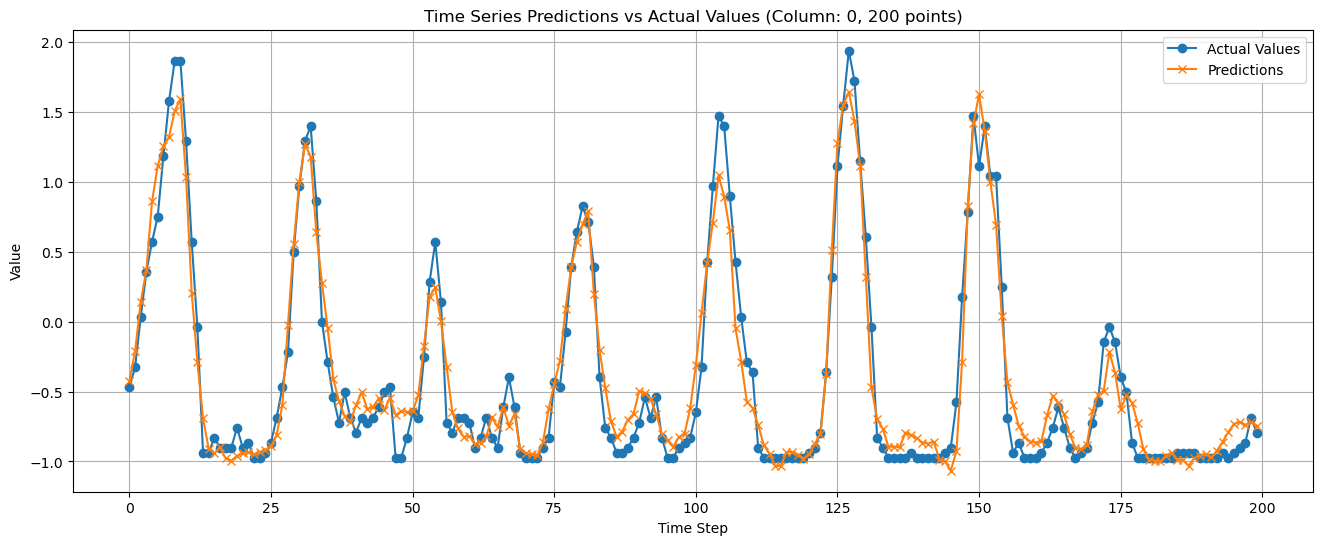

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already run the code in pytorch_forecast_v2_ar_cleaning.py 
# up to the point where base_predictor is trained and X_df_train_tensor,
# Y_df_train_tensor, sequence_length, and device are defined.

def plot_time_series_predictions(base_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_length, device, num_points=200, target_column_index=0):
    """
    Plots a time series of predictions vs. actual values for a specific column over a sequence of data points.

    Args:
        base_predictor: The trained BasePredictor model.
        X_df_train_tensor: The input data tensor.
        Y_df_train_tensor: The target data tensor.
        sequence_length: The length of the input sequences.
        device: The device to use ('cuda' or 'cpu').
        num_points: The number of data points to include in the time series plot.
        target_column_index: The index of the column in Y_df_train_tensor to plot.
    """
    base_predictor.eval()  # Set the model to evaluation mode

    predictions = []
    actual_values = []
    # Ensure we have enough data points
    total_possible_points = len(X_df_train_tensor) - sequence_length
    if num_points > total_possible_points:
        num_points = total_possible_points
        print(f"Warning: requested {num_points} is larger than total_possible_points: {total_possible_points}, will use {num_points} points")

    with torch.no_grad():
        for i in range(num_points):
            start_idx = i  # Move through the sequence, one step at a time
            
            # Check if the sequence fits in the dataset:
            if start_idx + sequence_length >= len(X_df_train_tensor):
                print(f"skipping sequence with index: {start_idx}, not enough examples in dataset")
                continue

            # Create the input sequence
            input_sequence = X_df_train_tensor[start_idx:start_idx + sequence_length, :]
            input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)

            # Make the prediction
            prediction = base_predictor(input_sequence_flat)

            # Get the corresponding actual value for the target column
            actual_value = Y_df_train_tensor[start_idx + sequence_length, target_column_index]

            # Extract the prediction for the target column
            prediction_for_column = prediction[0, target_column_index]

            predictions.append(prediction_for_column.cpu().numpy())
            actual_values.append(actual_value.cpu().numpy())

    # Plotting
    plt.figure(figsize=(16, 6))  # Increased figure size for a longer time series
    plt.plot(actual_values, label='Actual Values', marker='o', linestyle='-')
    plt.plot(predictions, label='Predictions', marker='x', linestyle='-')

    plt.title(f'Time Series Predictions vs Actual Values (Column: {target_column_index}, {num_points} points)')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example Usage:
sequence_length = 6
num_points = 200  # Number of data points to plot
target_column_index = 0  # The column from Y_df_train_tensor to plot
plot_time_series_predictions(base_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_length, device, num_points, target_column_index)

In [27]:
#quiero hacer un modelo autorregresivo, pero primero quiero verificar que funcione de forma autorregresiva usando el modelo base
# coonsiderando el num de horas a predecir

#primero declarar y verificar el modelo instanciado en su forma autorregresiva:

# Algo paredido al siguiente, pero se le falta que se le especifique en num_hours_to_forecast



# # Instanciar el AutoregressivePredictor con el BasePredictor ya entrenado
# input_dim = X_df_train.shape[1]
# output_dim = Y_df_train.shape[1]
# sequence_length = 6
# num_steps = 4

# # ar_predictor = AutoregressivePredictor(base_predictor, input_dim, output_dim).to(device)


# class AutoregressivePredictor(nn.Module):
#     def __init__(self, base_predictor, input_dim, output_dim, sequence_length, num_hours_to_forecast):
#         super(AutoregressivePredictor, self).__init__()
#         self.base_predictor = base_predictor
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.sequence_length = sequence_length
#         self.num_hours_to_forecast = num_hours_to_forecast


#     def forward(self, initial_input, num_hours_to_forecast): #num_steps is now the number of 6 hour steps
#         predictions = []
#         current_input = initial_input.clone() # Important: Create a copy to avoid modifying the original input

#         for _ in range(num_hours_to_forecast):
#             pred = self.base_predictor(current_input)
#             predictions.append(pred)
#             current_input = self.update_inputs(current_input, pred)

#         return torch.cat(predictions, dim=1) #concatenates along the time dimension

#     def update_inputs(self, inputs, preds):
#         # Correctly handles input dimensions for autoregression
#         # Removes the oldest 6 hours worth of data and adds the new predictions
#         inputs = torch.cat((inputs[:, self.input_dim*6:], preds), dim=1) #Adjust for sequence length
#         return inputs

# # Ahora creamos el AutoregressivePredictor
# ar_predictor = AutoregressivePredictor(base_predictor, input_dim, output_dim, sequence_length, num_hours_to_forecast).to(device)

In [28]:
import torch
import torch.nn as nn

class AutoregressivePredictor(nn.Module):
    def __init__(self, base_predictor, input_dim, output_dim, sequence_length, num_hours_to_forecast):
        super(AutoregressivePredictor, self).__init__()
        self.base_predictor = base_predictor
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.sequence_length = sequence_length
        self.num_hours_to_forecast = num_hours_to_forecast

    def forward(self, initial_input):
        predictions = []
        current_input = initial_input.clone()

        for _ in range(self.num_hours_to_forecast):
            # Flatten the input before passing to the base predictor
            flattened_input = current_input.reshape(current_input.size(0), -1)
            pred = self.base_predictor(flattened_input)
            predictions.append(pred)  # Append the prediction for this step
            
            # Reshape prediction to match input's structure
            pred_reshaped = pred.unsqueeze(1)
            current_input = self.update_inputs(current_input, pred_reshaped)

        # Stack the predictions to have shape (batch_size, num_hours_to_forecast, output_dim)
        return torch.stack(predictions, dim=1)
    
    def update_inputs(self, inputs, preds):
        # Reshape inputs to 2D: (batch_size, total_features)
        inputs_2d = inputs.reshape(inputs.size(0), -1)
        
        # Remove the first input_dim * (sequence_length - 1) features
        inputs_sliced = inputs_2d[:, self.input_dim:]
        
        # Concatenate sliced inputs with predictions
        updated_inputs = torch.cat((inputs_sliced, preds.reshape(preds.size(0), -1)), dim=1)
        
        # Reshape to original sequence structure
        return updated_inputs.reshape(updated_inputs.size(0), self.sequence_length, self.input_dim)

In [29]:
# ... (Your data loading and other code from the notebook) ...

# Example usage
sequence_length = 6
num_hours_to_forecast_list = [2, 6, 12, 24]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example input (replace with your actual data)
example_input = X_df_train_tensor[:sequence_length, :].unsqueeze(0).to(device)

In [30]:
# Define un índice para obtener la secuencia
sequence_start_idx = 0  # Puedes cambiar este índice para probar diferentes partes del set de entrenamiento

# Crear la secuencia de entrada
input_sequence = X_df_train_tensor[sequence_start_idx:sequence_start_idx + sequence_length, :]
# Aplanar la secuencia
input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)  # Añadir dimensión para batch

# Realizar la evaluación con el modelo
base_predictor.eval()  # Establecer el modo de evaluación

with torch.no_grad():  # Desactiva el cálculo del grafo de autograd para ahorrar memoria
    prediction = base_predictor(input_sequence_flat)

print(prediction)

tensor([[-0.4259, -0.6212, -0.4200, -0.6622, -0.6270, -0.4483, -0.3816, -0.5063,
         -0.5316, -0.4524, -0.4663, -0.4999, -0.3664, -0.4312, -0.4516, -0.2543,
         -0.3272, -0.3581, -0.3158, -0.4253, -0.3532, -0.3491, -0.5011, -0.4593,
         -0.6455, -0.4541, -0.4544, -0.6675, -0.6079, -0.4788, -0.3104, -0.0550,
         -0.0997, -0.1660, -0.1190, -0.1280, -0.0742, -0.1218, -0.1793, -0.3225,
         -0.0392, -0.3122, -0.0257, -0.1213, -0.1137, -0.0752, -0.1226, -0.0767,
         -0.1201, -0.1283, -1.0013, -0.7559, -0.7605, -0.8224, -1.1833, -0.5039,
         -0.7842, -0.5439, -1.0883, -1.1660, -1.0054, -1.2105, -0.8743, -1.1032,
         -1.2722, -0.9056, -1.1529, -1.1272, -0.8497, -1.0578, -0.8819, -1.0527,
         -1.0886, -1.0807, -0.2576, -1.0101, -0.7547, -0.9005, -0.4550, -0.5056,
         -0.2793, -0.3024, -0.5670, -0.6062, -0.5081, -0.3430, -0.5168, -0.3652,
         -0.5171, -0.4370, -0.5171, -0.4188, -0.6131, -0.5033, -0.6098, -0.8748,
         -0.3972, -0.0886, -

In [31]:
input_sequence_flat
len(input_sequence_flat[0])

1344

In [32]:
import torch
import matplotlib.pyplot as plt

def plot_instance(num_hours, base_predictor, input_dim, output_dim, sequence_length, input_sequence_flat, device,column_eval=0):
    """
    Instancia el predictor para el número de horas especificado,
    calcula la predicción y la grafica para la columna 0.
    
    Parámetros:
      - num_hours: número de horas a predecir (por ejemplo, 4, 48, etc.)
      - base_predictor: modelo base para la predicción
      - input_dim: dimensión de entrada
      - output_dim: dimensión de salida
      - sequence_length: longitud de la secuencia de entrada
      - input_sequence_flat: tensor de entrada
      - device: dispositivo de cómputo (e.g., torch.device('cuda:0'))
    """
    
    print("Input dim:", input_dim)
    # Instanciar el predictor con el número de horas deseado
    ar_predictor = AutoregressivePredictor(
        base_predictor,
        input_dim,
        output_dim,
        sequence_length,
        num_hours_to_forecast=num_hours
    ).to(device)
    
    ar_predictor.eval()  # Establecer modo de evaluación
    print(f"input_sequence_flat shape: {input_sequence_flat.shape}")
    
    with torch.no_grad():  # Desactiva el cálculo del grafo de autograd para ahorrar memoria
        prediction = ar_predictor(input_sequence_flat)
    
    print("Predicción:")
    print(prediction)
    print("Largo:", len(prediction))
    print("Shape:", prediction.shape)
    
    # Extraer la columna 0 (column_eval = 0)
    pred = prediction.cpu().numpy()[0, :, column_eval]
    
    # Crear el eje de tiempo (cada punto representa una hora)
    horas_range = range(1, len(pred) + 1)
    
    # Graficar la predicción
    plt.figure(figsize=(8, 4))
    plt.plot(horas_range, pred, marker='o')
    plt.title(f'Predicción ({num_hours} horas) - Columna {column_eval}')
    plt.xlabel('Horas')
    plt.ylabel('Valor predicho')
    plt.grid(True)
    plt.show()



Input dim: 224
input_sequence_flat shape: torch.Size([1, 1344])
Predicción:
tensor([[[-4.2593e-01, -6.2125e-01, -4.2003e-01, -6.6224e-01, -6.2700e-01,
          -4.4835e-01, -3.8155e-01, -5.0628e-01, -5.3161e-01, -4.5240e-01,
          -4.6632e-01, -4.9990e-01, -3.6635e-01, -4.3115e-01, -4.5160e-01,
          -2.5426e-01, -3.2716e-01, -3.5810e-01, -3.1582e-01, -4.2526e-01,
          -3.5324e-01, -3.4905e-01, -5.0105e-01, -4.5928e-01, -6.4549e-01,
          -4.5407e-01, -4.5436e-01, -6.6754e-01, -6.0789e-01, -4.7881e-01,
          -3.1035e-01, -5.5015e-02, -9.9747e-02, -1.6599e-01, -1.1903e-01,
          -1.2795e-01, -7.4162e-02, -1.2178e-01, -1.7930e-01, -3.2252e-01,
          -3.9216e-02, -3.1224e-01, -2.5673e-02, -1.2127e-01, -1.1372e-01,
          -7.5223e-02, -1.2260e-01, -7.6682e-02, -1.2005e-01, -1.2830e-01,
          -1.0013e+00, -7.5587e-01, -7.6051e-01, -8.2243e-01, -1.1833e+00,
          -5.0386e-01, -7.8416e-01, -5.4391e-01, -1.0883e+00, -1.1660e+00,
          -1.0054e+00, -

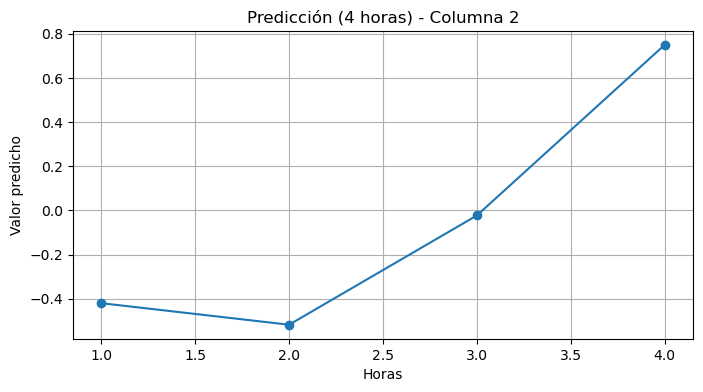

Input dim: 224
input_sequence_flat shape: torch.Size([1, 1344])
Predicción:
tensor([[[-0.4259, -0.6212, -0.4200,  ...,  0.7382,  0.2490,  1.6554],
         [-0.4833, -0.6465, -0.5177,  ...,  0.5508,  0.0519,  1.5476],
         [-0.0116, -0.1644, -0.0224,  ...,  0.5034, -0.1051,  1.5035],
         ...,
         [-0.1461, -0.4653, -0.4221,  ..., -1.4912,  0.6916,  1.5707],
         [-0.4991, -0.7555, -0.7528,  ..., -1.4349,  0.6329,  1.6192],
         [-0.6999, -0.9714, -0.9557,  ..., -1.3938,  0.6427,  1.6445]]],
       device='cuda:0')
Largo: 1
Shape: torch.Size([1, 48, 224])


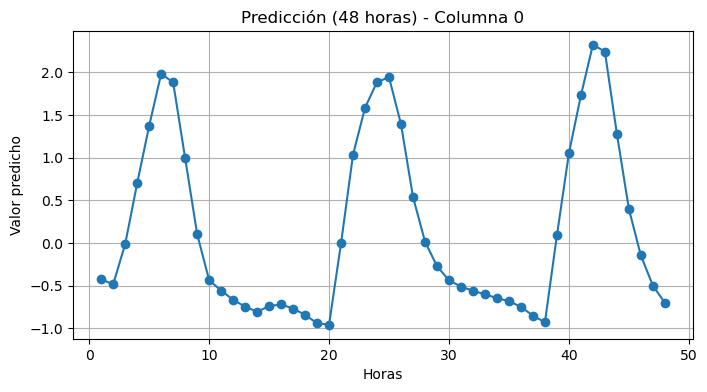

In [33]:
# Caso de 4 horas
plot_instance(4, base_predictor, input_dim, output_dim, sequence_length, input_sequence_flat, device, column_eval=2)

# Caso de 48 horas
plot_instance(48, base_predictor, input_dim, output_dim, sequence_length, input_sequence_flat, device, column_eval=0)

In [34]:
from torch.utils.data import Dataset

class AutoregressiveTimeSeriesDataset(Dataset):
    def __init__(self, X_data, Y_data, sequence_length, num_hours_to_forecast):
        self.X_data = X_data
        self.Y_data = Y_data
        self.sequence_length = sequence_length
        self.num_hours_to_forecast = num_hours_to_forecast

    def __len__(self):
        return len(self.X_data) - self.sequence_length - self.num_hours_to_forecast + 1

    def __getitem__(self, idx):
        X_sequence = self.X_data[idx:idx + self.sequence_length, :]
        X_sequence_flat = X_sequence.reshape(-1)

        # Recoger múltiples pasos de tiempo como las etiquetas (Y)
        Y_targets = self.Y_data[idx + self.sequence_length:idx + self.sequence_length + self.num_hours_to_forecast, :]

        return X_sequence_flat, Y_targets



num_hours_to_forecast = 48
# Crear el DataLoader para el modelo autoregresivo
train_ar_dataset = AutoregressiveTimeSeriesDataset(X_df_train_tensor, Y_df_train_tensor, sequence_length, num_hours_to_forecast)
train_ar_loader = DataLoader(train_ar_dataset, batch_size=batch_size, shuffle=True)

# Crear el validation DataLoader
val_ar_dataset = AutoregressiveTimeSeriesDataset(X_df_val_tensor, Y_df_val_tensor, sequence_length, num_hours_to_forecast)
val_ar_loader = DataLoader(val_ar_dataset, batch_size=batch_size, shuffle=False)

# Verificar la forma del output
example_X, example_Y = train_ar_dataset[0]
print(f"Shape of X_sequence_flat: {example_X.shape}")  # Should be: (sequence_length * num_features,)
print(f"Shape of Y_targets: {example_Y.shape}")  # Should be: (num_hours_to_forecast, num_features)

Shape of X_sequence_flat: torch.Size([1344])
Shape of Y_targets: torch.Size([48, 224])


In [35]:
len(train_ar_dataset[0][0])

1344

In [36]:
len(val_ar_dataset[0][0])

1344

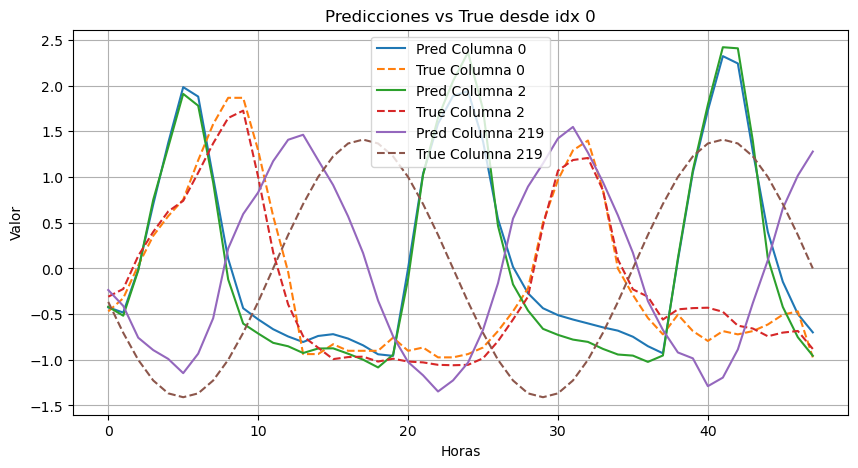

In [37]:
import torch
import matplotlib.pyplot as plt

def evaluate_and_plot(ar_predictor, X_data, Y_data, sequence_start_idx, num_hours_to_forecast, sequence_length, device, columns):
    """
    Evalúa el modelo autoregresivo y grafica las predicciones versus los valores reales para columnas específicas.

    Parámetros:
    - ar_predictor: el modelo AutoregressivePredictor.
    - X_data: los datos de entrada.
    - Y_data: los datos de salida.
    - sequence_start_idx: índice de inicio de la secuencia a evaluar.
    - num_hours_to_forecast: número de horas a predecir.
    - sequence_length: longitud de la secuencia de entrada.
    - device: dispositivo ('cuda' o 'cpu').
    - columns: lista de índices de columna para graficar.
    """
    # Crear la secuencia de entrada
    input_sequence = X_data[sequence_start_idx:sequence_start_idx + sequence_length, :]
    input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)  # Aplanamos y añadimos dimensión para batch

    # Obtener las etiquetas reales para las horas futuras
    actual_targets = Y_data[sequence_start_idx + sequence_length:sequence_start_idx + sequence_length + num_hours_to_forecast, :]

    # Evaluar el modelo
    ar_predictor.eval()
    with torch.no_grad():
        predictions = ar_predictor(input_sequence_flat)

    # Redimensionar para facilitar la gráfica
    pred_np = predictions.cpu().numpy().squeeze()
    actual_np = actual_targets.cpu().numpy()

    # Graficar solo las columnas especificadas
    plt.figure(figsize=(10, 5))
    for col_idx in columns:
        plt.plot(pred_np[:, col_idx], label=f'Pred Columna {col_idx}')
        plt.plot(actual_np[:, col_idx], label=f'True Columna {col_idx}', linestyle='dashed')

    plt.title(f'Predicciones vs True desde idx {sequence_start_idx}')
    plt.xlabel('Horas')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso
columns_to_plot = [0, 2, 219]  # Aquí indicas las columnas que quieres graficar
num_hours_to_forecast = 48
ar_predictor = AutoregressivePredictor(base_predictor, input_dim, output_dim, sequence_length, num_hours_to_forecast).to(device)

evaluate_and_plot(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_start_idx=0, num_hours_to_forecast=num_hours_to_forecast, sequence_length=sequence_length, device=device, columns=columns_to_plot)

In [38]:
learning_rate = 0.001
num_epochs = 30
criterion = nn.MSELoss()

def train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader):
    optimizer = optim.Adam(ar_predictor.parameters(), lr=learning_rate)
    ar_predictor.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_ar_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Predicción para múltiples pasos
            outputs = ar_predictor(x_batch)
            
            # Comparar el output completo de todos los pasos con las etiquetas
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        ar_predictor.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in val_ar_loader:
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                val_outputs = ar_predictor(x_val_batch)
                val_loss += criterion(val_outputs, y_val_batch).item()
        
        val_loss /= len(val_ar_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss/len(train_ar_loader):.4f}, Val Loss: {val_loss:.4f}')


# Entrenamiento
train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader)

Epoch [10/30], Loss: 0.6001, Val Loss: 1.0652


Epoch [20/30], Loss: 0.5039, Val Loss: 1.0409


Epoch [30/30], Loss: 0.4591, Val Loss: 1.0494


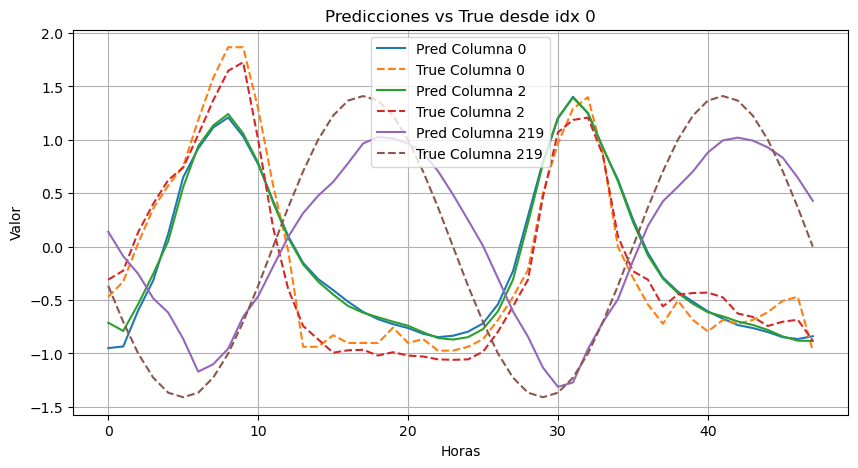

In [39]:
evaluate_and_plot(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_start_idx=0, num_hours_to_forecast=num_hours_to_forecast, sequence_length=sequence_length, device=device, columns=columns_to_plot)

Epoch [10/30], Loss: 0.4549, Val Loss: 1.0640


Epoch [20/30], Loss: 0.4242, Val Loss: 1.0739


Epoch [30/30], Loss: 0.4086, Val Loss: 1.1010


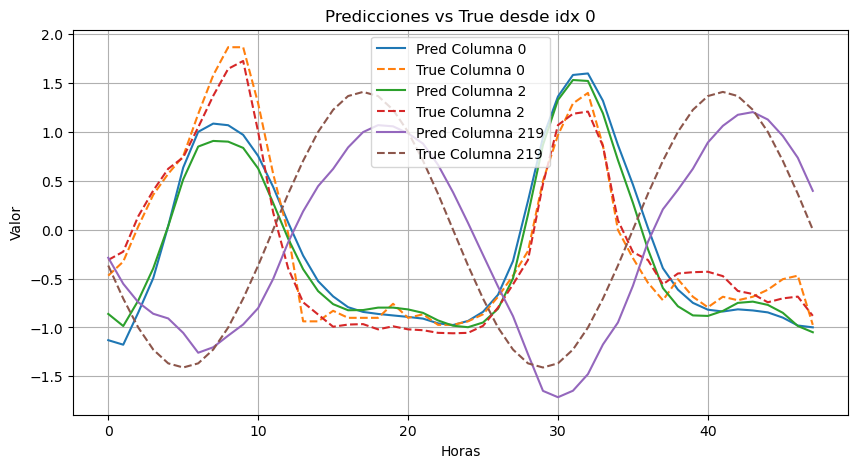

In [40]:
from torch.utils.tensorboard import SummaryWriter

learning_rate = 0.001
num_epochs = 30
criterion = nn.MSELoss()

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='./tensorboard_logs')

def train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader):
    optimizer = optim.Adam(ar_predictor.parameters(), lr=learning_rate)
    ar_predictor.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_ar_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Predicción para múltiples pasos
            outputs = ar_predictor(x_batch)
            
            # Comparar el output completo de todos los pasos con las etiquetas
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Log training loss to TensorBoard
        writer.add_scalar('Loss/train', epoch_loss / len(train_ar_loader), epoch)

        # Validation
        ar_predictor.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in val_ar_loader:
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                val_outputs = ar_predictor(x_val_batch)
                val_loss += criterion(val_outputs, y_val_batch).item()
        
        val_loss /= len(val_ar_loader)
        
        # Log validation loss to TensorBoard
        writer.add_scalar('Loss/val', val_loss, epoch)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss/len(train_ar_loader):.4f}, Val Loss: {val_loss:.4f}')

# Close the TensorBoard writer
writer.close()


# Entrenamiento
train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader)

evaluate_and_plot(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_start_idx=0, num_hours_to_forecast=num_hours_to_forecast, sequence_length=sequence_length, device=device, columns=columns_to_plot)

Epoch [10/30], Loss: 0.4088, Val Loss: 1.0598


Epoch [20/30], Loss: 0.3963, Val Loss: 1.0748


Epoch [30/30], Loss: 0.3876, Val Loss: 1.0821


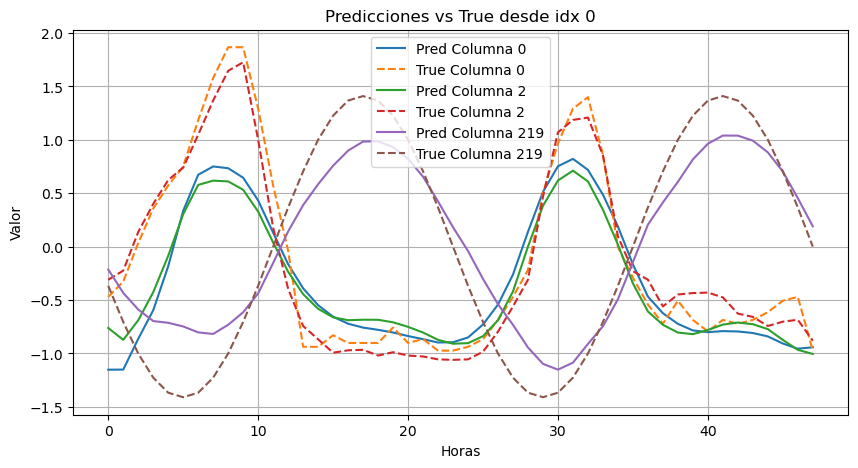

In [41]:
learning_rate = 0.0005
num_epochs = 30
criterion = nn.MSELoss()

def train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader):
    optimizer = optim.Adam(ar_predictor.parameters(), lr=learning_rate)
    ar_predictor.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_ar_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Predicción para múltiples pasos
            outputs = ar_predictor(x_batch)
            
            # Comparar el output completo de todos los pasos con las etiquetas
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        ar_predictor.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in val_ar_loader:
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                val_outputs = ar_predictor(x_val_batch)
                val_loss += criterion(val_outputs, y_val_batch).item()
        
        val_loss /= len(val_ar_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss/len(train_ar_loader):.4f}, Val Loss: {val_loss:.4f}')


# Entrenamiento
train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader)

evaluate_and_plot(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_start_idx=0, num_hours_to_forecast=num_hours_to_forecast, sequence_length=sequence_length, device=device, columns=columns_to_plot)

Epoch [10/30], Loss: 0.3920, Val Loss: 1.0650


Epoch [20/30], Loss: 0.3847, Val Loss: 1.0790


Epoch [30/30], Loss: 0.3766, Val Loss: 1.0844


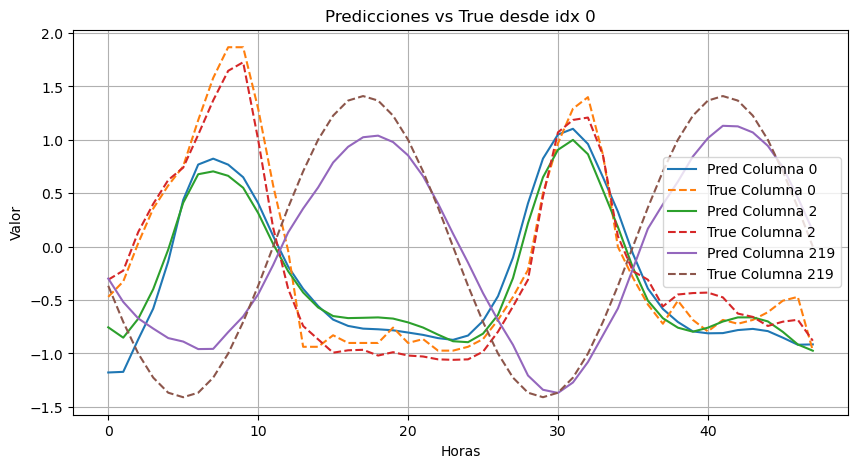

In [42]:
# Entrenamiento
train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader)

evaluate_and_plot(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_start_idx=0, num_hours_to_forecast=num_hours_to_forecast, sequence_length=sequence_length, device=device, columns=columns_to_plot)

Epoch [105000], Loss: 0.3817, Val Loss: 1.0664


Epoch [205000], Loss: 0.3778, Val Loss: 1.0657


Epoch [305000], Loss: 0.3665, Val Loss: 1.0814


Epoch [405000], Loss: 0.3590, Val Loss: 1.0847


Epoch [505000], Loss: 0.3535, Val Loss: 1.0933


Epoch [605000], Loss: 0.3477, Val Loss: 1.1040


Epoch [705000], Loss: 0.3406, Val Loss: 1.1097


Epoch [805000], Loss: 0.3348, Val Loss: 1.1112


Epoch [905000], Loss: 0.3261, Val Loss: 1.1472


Epoch [1005000], Loss: 0.3229, Val Loss: 1.1831


Epoch [1105000], Loss: 0.3083, Val Loss: 1.2064


Epoch [1205000], Loss: 0.3018, Val Loss: 1.2344


Epoch [1305000], Loss: 0.3138, Val Loss: 1.2175


Epoch [1405000], Loss: 0.2920, Val Loss: 1.2395


Epoch [1505000], Loss: 0.2880, Val Loss: 1.2483


Epoch [1605000], Loss: 0.2824, Val Loss: 1.2634


Epoch [1705000], Loss: 0.2775, Val Loss: 1.2602


Epoch [1805000], Loss: 0.2784, Val Loss: 1.2711


Epoch [1905000], Loss: 0.2969, Val Loss: 1.2462


Epoch [2005000], Loss: 0.2739, Val Loss: 1.2820


Epoch [2105000], Loss: 0.2840, Val Loss: 1.2926


Epoch [2205000], Loss: 0.2626, Val Loss: 1.3090


Epoch [2305000], Loss: 0.2645, Val Loss: 1.3226


Epoch [2405000], Loss: 0.2558, Val Loss: 1.3068


Epoch [2505000], Loss: 0.2541, Val Loss: 1.3376


Epoch [2605000], Loss: 0.2512, Val Loss: 1.3215


Epoch [2705000], Loss: 0.2540, Val Loss: 1.3334


Epoch [2805000], Loss: 0.2474, Val Loss: 1.3364


Epoch [2905000], Loss: 0.2469, Val Loss: 1.3348


Epoch [3005000], Loss: 0.2439, Val Loss: 1.3314


Early stopping at epoch 303


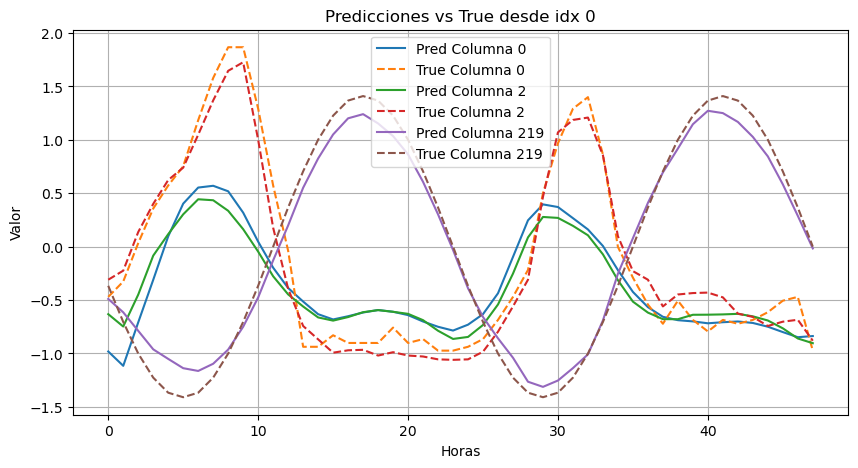

In [43]:
from torch.utils.tensorboard import SummaryWriter

learning_rate = 0.001
num_epochs = 5000
patience = 300
criterion = nn.MSELoss()

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='./tensorboard_logs')

def train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader):
    optimizer = optim.Adam(ar_predictor.parameters(), lr=learning_rate)
    ar_predictor.train()

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_ar_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Predicción para múltiples pasos
            outputs = ar_predictor(x_batch)
            
            # Comparar el output completo de todos los pasos con las etiquetas
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Log training loss to TensorBoard
        writer.add_scalar('Loss/train', epoch_loss / len(train_ar_loader), epoch)

        # Validation
        ar_predictor.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in val_ar_loader:
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                val_outputs = ar_predictor(x_val_batch)
                val_loss += criterion(val_outputs, y_val_batch).item()
        
        val_loss /= len(val_ar_loader)
        
        # Log validation loss to TensorBoard
        writer.add_scalar('Loss/val', val_loss, epoch)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}{num_epochs}], Loss: {epoch_loss/len(train_ar_loader):.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    # Close the TensorBoard writer
    writer.close()

# Entrenamiento
train_autoregressive_model(ar_predictor, train_ar_loader, val_ar_loader)

evaluate_and_plot(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_start_idx=0, num_hours_to_forecast=num_hours_to_forecast, sequence_length=sequence_length, device=device, columns=columns_to_plot)